# Best Wordle Words

[Wordle](https://www.powerlanguage.co.uk/wordle/) is extremely popular these days,
and for good reason: it is so simple and elegant; a real joy.

*Wordle* reminds us that the best of games are simple in nature, with few rules,
and a great deal of freedom for players to develop their own strategies.
But, don't let *Wordle*'s apparent simplicity fool you... it is all too easy
to guess words ineffectively, and to lose!

In this arrticle I will try to come up with some good words for initial guesses to *Wordle*.

## 5-Letter Words

Let's assume that the only rule to *Wordle*'s choice of words is that it is a 5-letter word.
So, let's just get all 5-letter words.

In [1]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import requests

words_request = requests.get(
    "https://gist.githubusercontent.com/nicobako/759adb8f0e7fa514f408afb946e80042/raw/d9783627c731268fb2935a731a618aa8e95cf465/words"
)
all_words = words_request.content.decode("utf-8").lower().split()

five_letter_words = pd.DataFrame(
    (
        word
        for word in all_words
        if len(word) == 5 and all(l in string.ascii_lowercase for l in word)
    ),
    columns=["word"],
)

How many 5-letter words do we have?

In [2]:
len(five_letter_words)

6071

Wow! That's a lot!

## Criteria for a Good Guess

There are many theories on what makes a good guess,
so please don't judge... but here is my naive simple criteria for a good guess:

* Contains as many common letters as possible
* Contains as many different letters as possible
* Contains as many letters in common places as possible

For now, let's keep it this simple. We can always make things more complicated later...

## Collecting the Data

This is not so tricky...
We look at each word, look at which letters we find at each position in each word,
and keep track of everything.
Later we can use this data to calculate everything we need.

In [3]:
def get_letters_data():
    data = []
    for word in five_letter_words["word"]:
        for position, letter in enumerate(word):
            data.append({"letter": letter, "position": position + 1})
    return pd.DataFrame(data)


letters = get_letters_data()

This data is a table whose rows contain two values: a letter; its position in a word.
It might not seem like much, but it's all we need. Here's a quick glance at what
this table looks like:

In [4]:
letters.head()

,letter,position
0,a,1
1,a,2
2,r,3
3,o,4
4,n,5


## Most Common Letters

Given our data, we can now count the occurences of each letter.
This reflects how commonly each letter is found in any word.
To calculate this we take a look at our letters data,
group them by letter, and tally up the count.

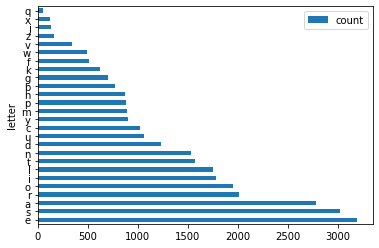

In [5]:
letters_count = letters.groupby("letter").count()
letters_count.columns = ["count"]
letters_count = letters_count.sort_values(by="count", ascending=False)
letters_count.plot.barh(y="count")
plt.show()

I don't know about you, but these results surprised me!
The top 10 letters are:

In [6]:
letters_count.head(10)

,count
letter,
e,3187
s,3019
a,2785
r,2006
o,1946
i,1776
l,1746
t,1574
n,1535


And the lowest 10 are:

In [7]:
letters_count.tail(10)

,count
letter,
b,768
g,704
k,620
f,514
w,494
v,343
z,160
j,136
x,117


Let's create a new column in our letters-count table
with the percent occurence of each letter:

In [8]:
letters_count["percent"] = 100 * letters_count["count"] / letters_count["count"].sum()

As usual, the sum of the percent column should equal 100%.

In [9]:
letters_count["percent"].sum()

100.0

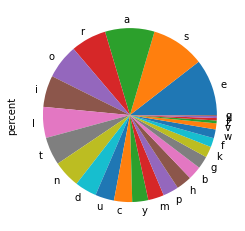

In [10]:
letters_count["percent"].plot.pie(y="letter")
plt.show()

## Words With Most Common Letters

Using the occurence of each letter, we can look
at all of our words, and give them a score
based on how common the letters of the word are.

We also don't want to give words extra points for having
the same letter multiple times... Remember, the whole
point of this is to come up with a good first guess for Wordle,
so it would be more helpful if our first guess contained unique letters.

In [11]:
def score_based_on_letters_count(word: str) -> float:
    score = 0.0
    unique_letters = list(set(word))
    for letter in unique_letters:
        score += letters_count.loc[letter].percent
    return score

In this way, the score of a letter like `apple` is:

In [12]:
score_based_on_letters_count("apple")

28.34129467962444

We can take this metric and calculate a score for all of our 5-letter words.

In [13]:
five_letter_words["score_letters_count"] = [
    score_based_on_letters_count(word) for word in five_letter_words["word"]
]

Let's take a look at some of the top words:

In [14]:
five_letter_words.sort_values("score_letters_count", ascending=False).head(
    10
).set_index("word")

,score_letters_count
word,
arose,42.638775
aries,42.078735
raise,42.078735
arise,42.078735
laser,41.979904
reals,41.979904
earls,41.979904
aloes,41.782243
rates,41.413276


## Most Common Positions of Letters

Another important thing to look at is the relative position of the
letters in our first guess. We want a word whose letters
are not only common, but whose positions of letters are in common places.

This is a little trickier to do, but stil not that tough.
We group our data by letter and position, and count how many occurences
of each letter-position combination.

In [15]:
letters_position = pd.DataFrame(
    {"count": letters.groupby(["letter", "position"]).size()}
)

Here's what it looks like for the letter `a`

In [16]:
letters_position.loc["a"]

,count
position,
1,338
2,1076
3,646
4,412
5,313


You  can see that `a` is most commonly in the second position.

Let's create a *percent* column for this table as well.

In [17]:
letters_position["percent"] = (
    100 * letters_position["count"] / letters_position["count"].sum()
)

Let's make sure the sum of the percent is 100%.

In [18]:
letters_position["percent"].sum()

100.0

And here's a fancy chart displaying how the letters and positions
look for each letter:

In [19]:
letters_position_pivoted = letters_position.reset_index().pivot(
    index="letter", columns="position", values="percent"
)
letters_position_pivoted.sort_values("letter")
letters_position_pivoted.style.background_gradient("YlGn")

position,1,2,3,4,5
letter,,,,,
a,1.113490,3.544721,2.128150,1.357272,1.031132
b,1.479163,0.131774,0.507330,0.339318,0.072476
c,1.518695,0.260254,0.596277,0.849942,0.144951
d,1.073958,0.187778,0.658870,0.784055,1.353978
e,0.579806,2.408170,1.291385,3.976281,2.243452
f,0.994894,0.042827,0.233899,0.293197,0.128480
g,0.929007,0.072476,0.533685,0.579806,0.204250
h,0.833471,0.912535,0.131774,0.253665,0.741229
i,0.286608,2.210509,1.848130,1.205732,0.299786


This chart is really quite useful, from a glance you can see that
some letters are much more likely to be in certain positions of the word,
so when making guesses, it's important to keep this in mind.

## Words with Most Common Letter Positions

We can use the above data to score each of our 5-letter words
based on the positions of the letters.
We just look at all of the letters of our word and their corresponding
positions, and tally up the percent chance of encountering each
letter in its position.

Here will count all letters, even duplicates... not sure why, it just feels right.

In [20]:
def score_based_on_letters_position(word: str) -> float:
    score = 0.0
    for i, letter in enumerate(word):
        position = i + 1
        score += letters_position.loc[letter, position]["percent"]
    return score

So, the score of `apple` in this case would be:

In [21]:
score_based_on_letters_position("apple")

5.442266512930325

You can see right away that the score for the word `apple` is very different than before.

Let's calculate the score for each of our 5-letter words based on the positions
of its letters.

In [22]:
five_letter_words["score_letters_position"] = [
    score_based_on_letters_position(word) for word in five_letter_words["word"]
]

Let's take a look at the top 10 in this case.

In [30]:
five_letter_words.sort_values("score_letters_position", ascending=False).head(
    10
).set_index("word").style.background_gradient("YlGn")

,score_letters_count,score_letters_position,final_score
word,,,
sales,35.371438,17.005436,52.376874
sores,33.464009,16.814363,50.278373
sates,34.804810,16.471751,51.276561
soles,32.607478,16.438807,49.046286
cares,39.598089,16.402570,56.000659
bares,38.758030,16.363037,55.121067
sames,32.561357,16.297150,48.858508
sades,33.678142,16.234558,49.912700
tares,41.413276,16.125844,57.539120


You may be surprised, as I was, to find that these two ways of scoring words
generated very different lists!

## What is the Best Guess?

So, what is the best first guess.
We'll naively assume that is a combination of these two scoring methods.
We'll just add up the scores for letter-count and letter-position,
and look at the top words.

In [24]:
five_letter_words["final_score"] = (
    five_letter_words["score_letters_count"]
    + five_letter_words["score_letters_position"]
)

In [29]:
five_letter_words.sort_values("final_score", ascending=False).set_index("word").head(
    20
).style.background_gradient("YlGn")

,score_letters_count,score_letters_position,final_score
word,,,
tares,41.413276,16.125844,57.539120
tales,40.556745,15.750288,56.307033
rates,41.413276,14.873991,56.287267
dares,40.286608,15.957832,56.244441
aries,42.078735,14.129468,56.208203
lanes,40.428266,15.575688,56.003953
cares,39.598089,16.402570,56.000659
oates,41.215615,14.333718,55.549333
aloes,41.782243,13.506836,55.289079


## Conclusion

Don't let this fancy code and math fool you,
this is a naive approach. We are simply looking at
which letters are most common, and which positions of letters
are most common, and picking words that maximize this combination.
There are a ton of other details that this code simply isn't considering,
and a lot of ways this code can be improved.

In the end, this article may help you come up with a decent first guess,
but the rest is up to you! Anyway, good luck on your next *Wordle*  game,
and don't forget to try out one of the top words!